# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
#data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

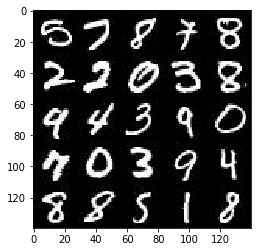

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

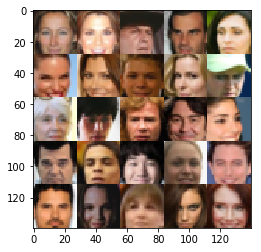

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    :param image_width:
    :param image_height:
    :param image_channels:
    :param z_dim:
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, None)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(x, reuse=False):
    """
    Create descriminator network
    :param x: input images tensor (x)
    :param reuse: weights shoudl be reused or not
    :return: Tuple of descriminator, tensor logits of the descriminator
    """

    alpha = 0.2

    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2 * 2 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the generator and descriminiator
    :param input_real: real images
    :param input_z: random vector
    :param out_channel_dim: number of output channels
    :return: tuple of descriminator loss and generator loss
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    get optimization operations
    :param d_loss: discriminator train loss
    :param g_loss: generator train loss
    :param learning_rate: learning rate placeholder
    :param beta1: exponential decay rate for the 1st moment in the optimizer
    :return: tuple of (discriminator training op, genarator training op)
    """

    #get weights and biases to update optimizer
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opts = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opts = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opts, g_train_opts


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    n_samples, width, height, out_channels = data_shape

    input_real, input_z, learn_rate = model_inputs(width, height, out_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    samples = []
    losses = []
    steps = 0

    show_generator_output_every = 100
    n_images = 25
    print_every = 10

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                # I Run the generator optimizer 2 times to slow down convergence of the discriminator network
                # This makes a huge difference on training speed for my generator !
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate })
                #_ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate:learning_rate, is_train:True})

                if steps % show_generator_output_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channels, data_image_mode)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 4.6863... Generator Loss: 0.0111
Epoch 0/2... Discriminator Loss: 3.3030... Generator Loss: 0.0426
Epoch 0/2... Discriminator Loss: 0.3398... Generator Loss: 11.1762
Epoch 0/2... Discriminator Loss: 0.8033... Generator Loss: 0.7951
Epoch 0/2... Discriminator Loss: 0.6948... Generator Loss: 9.4186
Epoch 0/2... Discriminator Loss: 1.6525... Generator Loss: 6.9145
Epoch 0/2... Discriminator Loss: 0.8832... Generator Loss: 5.3558
Epoch 0/2... Discriminator Loss: 0.1107... Generator Loss: 3.5039
Epoch 0/2... Discriminator Loss: 0.5376... Generator Loss: 5.3590


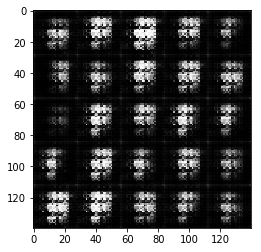

Epoch 0/2... Discriminator Loss: 0.3685... Generator Loss: 4.2599
Epoch 0/2... Discriminator Loss: 0.0473... Generator Loss: 4.5720
Epoch 0/2... Discriminator Loss: 0.0982... Generator Loss: 5.9810
Epoch 0/2... Discriminator Loss: 0.1623... Generator Loss: 2.7780
Epoch 0/2... Discriminator Loss: 0.1301... Generator Loss: 2.9528
Epoch 0/2... Discriminator Loss: 0.1246... Generator Loss: 3.0713
Epoch 0/2... Discriminator Loss: 0.1212... Generator Loss: 3.4631
Epoch 0/2... Discriminator Loss: 0.0719... Generator Loss: 3.5112
Epoch 0/2... Discriminator Loss: 0.1440... Generator Loss: 3.2771
Epoch 0/2... Discriminator Loss: 0.1956... Generator Loss: 3.7621


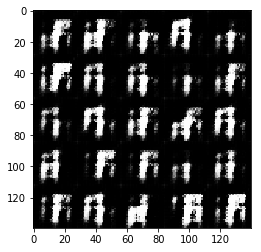

Epoch 0/2... Discriminator Loss: 0.4974... Generator Loss: 2.2492
Epoch 0/2... Discriminator Loss: 0.1628... Generator Loss: 3.3147
Epoch 0/2... Discriminator Loss: 0.1659... Generator Loss: 3.6802
Epoch 0/2... Discriminator Loss: 0.0566... Generator Loss: 4.3299
Epoch 0/2... Discriminator Loss: 0.0704... Generator Loss: 4.0247
Epoch 0/2... Discriminator Loss: 0.2637... Generator Loss: 3.1926
Epoch 0/2... Discriminator Loss: 0.1620... Generator Loss: 3.0331
Epoch 0/2... Discriminator Loss: 0.1442... Generator Loss: 2.7270
Epoch 0/2... Discriminator Loss: 2.4366... Generator Loss: 15.9370
Epoch 0/2... Discriminator Loss: 0.3361... Generator Loss: 2.3842


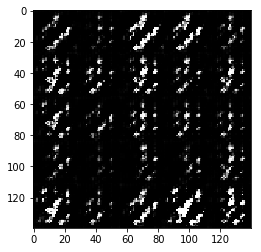

Epoch 0/2... Discriminator Loss: 0.1143... Generator Loss: 3.1908
Epoch 0/2... Discriminator Loss: 0.1471... Generator Loss: 2.9557
Epoch 0/2... Discriminator Loss: 0.3288... Generator Loss: 6.1476
Epoch 0/2... Discriminator Loss: 0.7475... Generator Loss: 1.3898
Epoch 0/2... Discriminator Loss: 0.1148... Generator Loss: 3.8484
Epoch 0/2... Discriminator Loss: 0.3150... Generator Loss: 2.1730
Epoch 0/2... Discriminator Loss: 0.2753... Generator Loss: 2.6807
Epoch 0/2... Discriminator Loss: 0.4343... Generator Loss: 2.0405
Epoch 0/2... Discriminator Loss: 0.6377... Generator Loss: 4.7206
Epoch 0/2... Discriminator Loss: 1.0541... Generator Loss: 7.8520


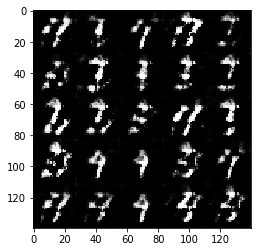

Epoch 0/2... Discriminator Loss: 0.2812... Generator Loss: 2.2153
Epoch 0/2... Discriminator Loss: 0.2559... Generator Loss: 2.8397
Epoch 0/2... Discriminator Loss: 0.4659... Generator Loss: 2.1584
Epoch 0/2... Discriminator Loss: 0.8009... Generator Loss: 1.6260
Epoch 0/2... Discriminator Loss: 0.3827... Generator Loss: 2.3905
Epoch 0/2... Discriminator Loss: 0.2478... Generator Loss: 2.4693
Epoch 0/2... Discriminator Loss: 0.1947... Generator Loss: 4.1008
Epoch 0/2... Discriminator Loss: 0.3913... Generator Loss: 2.2273
Epoch 0/2... Discriminator Loss: 0.6692... Generator Loss: 2.0607
Epoch 0/2... Discriminator Loss: 0.3797... Generator Loss: 1.9437


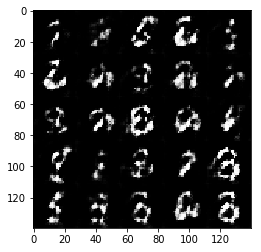

Epoch 0/2... Discriminator Loss: 0.6636... Generator Loss: 1.3291
Epoch 0/2... Discriminator Loss: 1.2002... Generator Loss: 5.2769
Epoch 0/2... Discriminator Loss: 0.4210... Generator Loss: 1.7496
Epoch 0/2... Discriminator Loss: 0.3853... Generator Loss: 2.2713
Epoch 0/2... Discriminator Loss: 0.6964... Generator Loss: 1.7350
Epoch 0/2... Discriminator Loss: 0.2589... Generator Loss: 2.2282
Epoch 0/2... Discriminator Loss: 0.4324... Generator Loss: 3.1907
Epoch 0/2... Discriminator Loss: 0.5217... Generator Loss: 1.6847
Epoch 0/2... Discriminator Loss: 0.5255... Generator Loss: 2.0078
Epoch 0/2... Discriminator Loss: 0.4079... Generator Loss: 3.8699


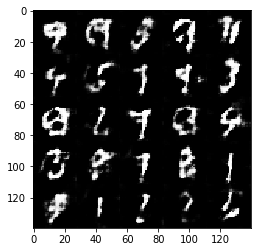

Epoch 0/2... Discriminator Loss: 0.5763... Generator Loss: 1.7387
Epoch 0/2... Discriminator Loss: 1.4376... Generator Loss: 4.6630
Epoch 0/2... Discriminator Loss: 0.6720... Generator Loss: 1.3491
Epoch 0/2... Discriminator Loss: 0.5955... Generator Loss: 1.9648
Epoch 0/2... Discriminator Loss: 0.6054... Generator Loss: 2.2233
Epoch 0/2... Discriminator Loss: 0.5883... Generator Loss: 3.5959
Epoch 0/2... Discriminator Loss: 0.6832... Generator Loss: 1.0838
Epoch 0/2... Discriminator Loss: 0.6642... Generator Loss: 1.3448
Epoch 0/2... Discriminator Loss: 0.7559... Generator Loss: 0.9444
Epoch 0/2... Discriminator Loss: 0.8202... Generator Loss: 2.4723


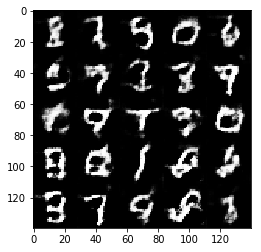

Epoch 0/2... Discriminator Loss: 1.1281... Generator Loss: 2.4510
Epoch 0/2... Discriminator Loss: 0.6941... Generator Loss: 1.2956
Epoch 0/2... Discriminator Loss: 0.5790... Generator Loss: 2.0461
Epoch 0/2... Discriminator Loss: 0.5288... Generator Loss: 1.7085
Epoch 0/2... Discriminator Loss: 0.5806... Generator Loss: 1.5557
Epoch 0/2... Discriminator Loss: 0.6194... Generator Loss: 2.0140
Epoch 0/2... Discriminator Loss: 0.7395... Generator Loss: 1.2298
Epoch 0/2... Discriminator Loss: 0.9036... Generator Loss: 0.8617
Epoch 0/2... Discriminator Loss: 0.5473... Generator Loss: 1.8099
Epoch 0/2... Discriminator Loss: 0.6235... Generator Loss: 1.7115


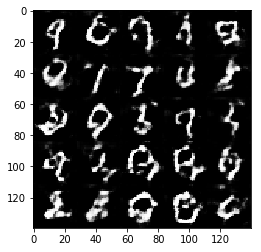

Epoch 0/2... Discriminator Loss: 0.6554... Generator Loss: 1.3555
Epoch 0/2... Discriminator Loss: 0.5696... Generator Loss: 1.9954
Epoch 0/2... Discriminator Loss: 0.7184... Generator Loss: 1.3221
Epoch 0/2... Discriminator Loss: 0.7212... Generator Loss: 1.0129
Epoch 0/2... Discriminator Loss: 0.8951... Generator Loss: 0.8401
Epoch 0/2... Discriminator Loss: 0.8232... Generator Loss: 2.5571
Epoch 0/2... Discriminator Loss: 0.8203... Generator Loss: 0.9457
Epoch 0/2... Discriminator Loss: 1.4254... Generator Loss: 3.3400
Epoch 0/2... Discriminator Loss: 0.9047... Generator Loss: 0.7860
Epoch 0/2... Discriminator Loss: 0.6975... Generator Loss: 1.2095


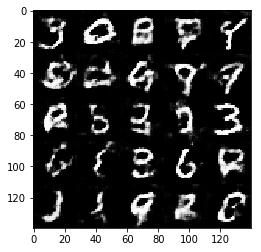

Epoch 0/2... Discriminator Loss: 0.6052... Generator Loss: 1.5149
Epoch 0/2... Discriminator Loss: 0.7352... Generator Loss: 1.1058
Epoch 0/2... Discriminator Loss: 0.7459... Generator Loss: 2.6368
Epoch 0/2... Discriminator Loss: 1.0866... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 2.1662
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 1.1882


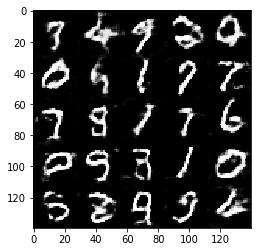

Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 1.5469
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 0.7025... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 2.1496... Generator Loss: 5.0534
Epoch 1/2... Discriminator Loss: 0.9150... Generator Loss: 1.0077
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 0.8253


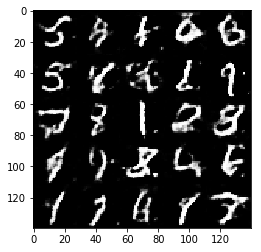

Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 2.5672
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 1.2506
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 1.9635
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.4911
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 2.3788
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 1.7356


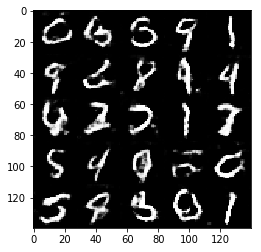

Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.5872
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 1.3154
Epoch 1/2... Discriminator Loss: 0.6711... Generator Loss: 1.5259
Epoch 1/2... Discriminator Loss: 0.6652... Generator Loss: 1.0814
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 3.3460
Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.5958
Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 2.1231
Epoch 1/2... Discriminator Loss: 0.6107... Generator Loss: 1.3686


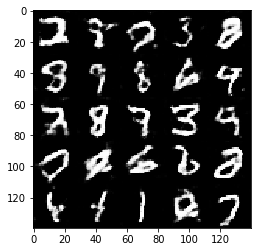

Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 0.3432
Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 1.2237
Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 1.5303
Epoch 1/2... Discriminator Loss: 1.8170... Generator Loss: 2.3835
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.3505
Epoch 1/2... Discriminator Loss: 0.8362... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 1.8367... Generator Loss: 0.2571


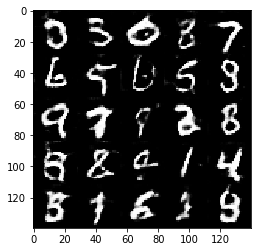

Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 0.7477... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 0.7720... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 1.1608
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 1.9216
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.5636
Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 1.7332
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.7236
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 0.7299


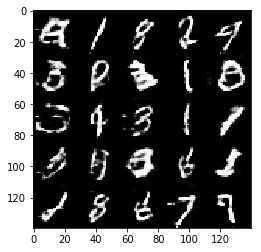

Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 0.9031
Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 2.3346... Generator Loss: 0.1505
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 0.6605... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 0.6445... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 0.6025... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 0.9536
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.4234


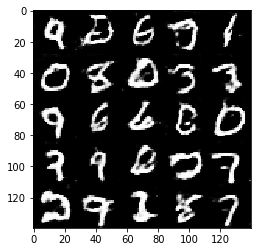

Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 2.9639
Epoch 1/2... Discriminator Loss: 0.6709... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 1.2692
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.2166
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 1.2258
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 2.2007


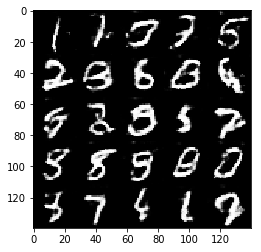

Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 2.1859
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 1.4194
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 0.7770... Generator Loss: 0.8952
Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 1.3565
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 2.2108
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 1.0363
Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 1.3194


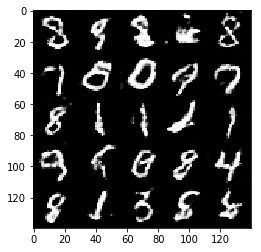

Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 1.3826
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 3.1706... Generator Loss: 5.3732
Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 1.2047
Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 1.2717
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 1.9007


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.2501... Generator Loss: 3.9302
Epoch 0/1... Discriminator Loss: 0.2081... Generator Loss: 10.8965
Epoch 0/1... Discriminator Loss: 0.1178... Generator Loss: 5.4971
Epoch 0/1... Discriminator Loss: 0.1439... Generator Loss: 15.1758
Epoch 0/1... Discriminator Loss: 0.5744... Generator Loss: 15.0669
Epoch 0/1... Discriminator Loss: 0.6133... Generator Loss: 10.6981
Epoch 0/1... Discriminator Loss: 0.2786... Generator Loss: 2.4089
Epoch 0/1... Discriminator Loss: 0.1169... Generator Loss: 3.0992
Epoch 0/1... Discriminator Loss: 0.5793... Generator Loss: 5.2878


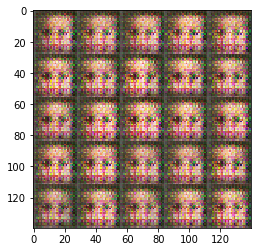

Epoch 0/1... Discriminator Loss: 0.7683... Generator Loss: 9.2720
Epoch 0/1... Discriminator Loss: 0.3463... Generator Loss: 4.7680
Epoch 0/1... Discriminator Loss: 0.4394... Generator Loss: 1.6079
Epoch 0/1... Discriminator Loss: 0.5697... Generator Loss: 1.0749
Epoch 0/1... Discriminator Loss: 0.2264... Generator Loss: 2.3933
Epoch 0/1... Discriminator Loss: 0.4403... Generator Loss: 1.6222
Epoch 0/1... Discriminator Loss: 0.3907... Generator Loss: 2.9547
Epoch 0/1... Discriminator Loss: 0.6778... Generator Loss: 1.1118
Epoch 0/1... Discriminator Loss: 0.1747... Generator Loss: 2.5859
Epoch 0/1... Discriminator Loss: 0.8652... Generator Loss: 0.9147


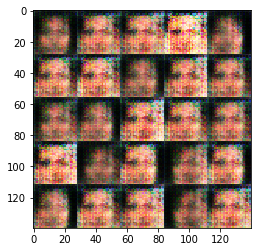

Epoch 0/1... Discriminator Loss: 1.0197... Generator Loss: 0.7416
Epoch 0/1... Discriminator Loss: 1.2064... Generator Loss: 3.3259
Epoch 0/1... Discriminator Loss: 1.0357... Generator Loss: 1.3681
Epoch 0/1... Discriminator Loss: 1.5152... Generator Loss: 3.5986
Epoch 0/1... Discriminator Loss: 1.3341... Generator Loss: 0.6427
Epoch 0/1... Discriminator Loss: 1.2128... Generator Loss: 0.8337
Epoch 0/1... Discriminator Loss: 0.6817... Generator Loss: 1.8443
Epoch 0/1... Discriminator Loss: 0.9581... Generator Loss: 1.4709
Epoch 0/1... Discriminator Loss: 1.0194... Generator Loss: 0.8737
Epoch 0/1... Discriminator Loss: 1.3481... Generator Loss: 0.8232


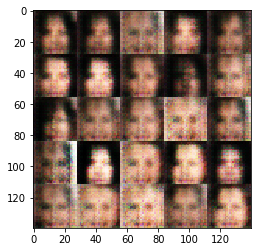

Epoch 0/1... Discriminator Loss: 1.2949... Generator Loss: 0.9779
Epoch 0/1... Discriminator Loss: 0.7717... Generator Loss: 1.6734
Epoch 0/1... Discriminator Loss: 1.0649... Generator Loss: 0.9098
Epoch 0/1... Discriminator Loss: 0.9921... Generator Loss: 1.0198
Epoch 0/1... Discriminator Loss: 1.2671... Generator Loss: 0.9032
Epoch 0/1... Discriminator Loss: 0.7784... Generator Loss: 1.8553
Epoch 0/1... Discriminator Loss: 1.1347... Generator Loss: 1.0511
Epoch 0/1... Discriminator Loss: 1.0191... Generator Loss: 0.7694
Epoch 0/1... Discriminator Loss: 1.4022... Generator Loss: 0.6422
Epoch 0/1... Discriminator Loss: 1.0861... Generator Loss: 1.2353


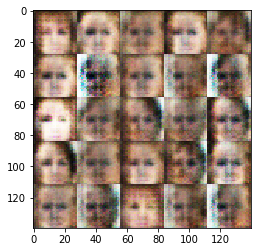

Epoch 0/1... Discriminator Loss: 1.0767... Generator Loss: 0.8133
Epoch 0/1... Discriminator Loss: 0.9049... Generator Loss: 1.1950
Epoch 0/1... Discriminator Loss: 0.8204... Generator Loss: 1.1483
Epoch 0/1... Discriminator Loss: 0.5302... Generator Loss: 1.9062
Epoch 0/1... Discriminator Loss: 1.2984... Generator Loss: 0.5435
Epoch 0/1... Discriminator Loss: 1.0205... Generator Loss: 0.8769
Epoch 0/1... Discriminator Loss: 1.0895... Generator Loss: 0.9773
Epoch 0/1... Discriminator Loss: 0.7358... Generator Loss: 1.5867
Epoch 0/1... Discriminator Loss: 0.8531... Generator Loss: 0.9469
Epoch 0/1... Discriminator Loss: 0.8780... Generator Loss: 1.0362


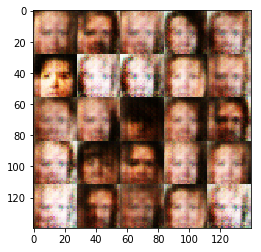

Epoch 0/1... Discriminator Loss: 0.9446... Generator Loss: 0.9862
Epoch 0/1... Discriminator Loss: 0.9377... Generator Loss: 1.0015
Epoch 0/1... Discriminator Loss: 1.0056... Generator Loss: 1.1272
Epoch 0/1... Discriminator Loss: 1.1217... Generator Loss: 1.8051
Epoch 0/1... Discriminator Loss: 0.8388... Generator Loss: 1.2242
Epoch 0/1... Discriminator Loss: 0.8821... Generator Loss: 1.1048
Epoch 0/1... Discriminator Loss: 0.9618... Generator Loss: 0.9379
Epoch 0/1... Discriminator Loss: 1.0895... Generator Loss: 0.7670
Epoch 0/1... Discriminator Loss: 0.9074... Generator Loss: 1.0553
Epoch 0/1... Discriminator Loss: 1.4940... Generator Loss: 0.4548


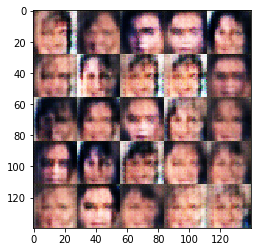

Epoch 0/1... Discriminator Loss: 0.7663... Generator Loss: 1.6413
Epoch 0/1... Discriminator Loss: 0.9842... Generator Loss: 1.1379
Epoch 0/1... Discriminator Loss: 1.0909... Generator Loss: 2.8073
Epoch 0/1... Discriminator Loss: 0.9222... Generator Loss: 0.7905
Epoch 0/1... Discriminator Loss: 0.6721... Generator Loss: 1.4651
Epoch 0/1... Discriminator Loss: 1.3377... Generator Loss: 0.4966
Epoch 0/1... Discriminator Loss: 1.1055... Generator Loss: 0.7876
Epoch 0/1... Discriminator Loss: 1.2788... Generator Loss: 3.0208
Epoch 0/1... Discriminator Loss: 0.6750... Generator Loss: 1.4213
Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 0.6511


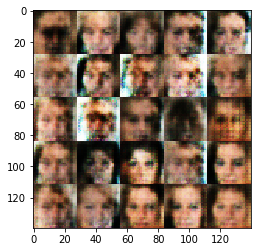

Epoch 0/1... Discriminator Loss: 1.2140... Generator Loss: 1.1399
Epoch 0/1... Discriminator Loss: 0.8453... Generator Loss: 1.1194
Epoch 0/1... Discriminator Loss: 0.9472... Generator Loss: 1.8027
Epoch 0/1... Discriminator Loss: 1.0061... Generator Loss: 0.8669
Epoch 0/1... Discriminator Loss: 2.0145... Generator Loss: 0.2006
Epoch 0/1... Discriminator Loss: 1.2407... Generator Loss: 0.5820
Epoch 0/1... Discriminator Loss: 0.8367... Generator Loss: 1.5209
Epoch 0/1... Discriminator Loss: 0.8907... Generator Loss: 1.2896
Epoch 0/1... Discriminator Loss: 0.9739... Generator Loss: 0.7214
Epoch 0/1... Discriminator Loss: 0.8606... Generator Loss: 1.3940


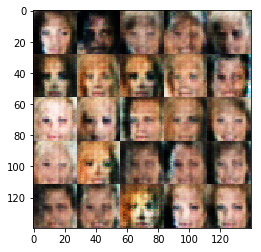

Epoch 0/1... Discriminator Loss: 0.5985... Generator Loss: 1.5322
Epoch 0/1... Discriminator Loss: 0.7821... Generator Loss: 1.5963
Epoch 0/1... Discriminator Loss: 0.8688... Generator Loss: 0.9353
Epoch 0/1... Discriminator Loss: 0.7993... Generator Loss: 1.8589
Epoch 0/1... Discriminator Loss: 0.7299... Generator Loss: 1.4431
Epoch 0/1... Discriminator Loss: 0.9396... Generator Loss: 1.5330
Epoch 0/1... Discriminator Loss: 1.3291... Generator Loss: 3.1797
Epoch 0/1... Discriminator Loss: 0.8942... Generator Loss: 0.8096
Epoch 0/1... Discriminator Loss: 0.8280... Generator Loss: 1.4298
Epoch 0/1... Discriminator Loss: 1.3151... Generator Loss: 0.5853


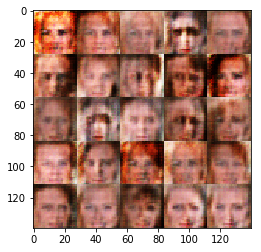

Epoch 0/1... Discriminator Loss: 1.0115... Generator Loss: 0.7899
Epoch 0/1... Discriminator Loss: 0.8349... Generator Loss: 1.0937
Epoch 0/1... Discriminator Loss: 1.4060... Generator Loss: 2.0370
Epoch 0/1... Discriminator Loss: 0.8787... Generator Loss: 1.2301
Epoch 0/1... Discriminator Loss: 1.0158... Generator Loss: 0.6904
Epoch 0/1... Discriminator Loss: 1.3613... Generator Loss: 0.6207
Epoch 0/1... Discriminator Loss: 1.5955... Generator Loss: 3.0459
Epoch 0/1... Discriminator Loss: 1.0453... Generator Loss: 1.0336
Epoch 0/1... Discriminator Loss: 1.0685... Generator Loss: 1.0137
Epoch 0/1... Discriminator Loss: 0.7142... Generator Loss: 1.5491


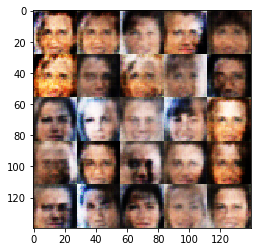

Epoch 0/1... Discriminator Loss: 0.8434... Generator Loss: 1.2079
Epoch 0/1... Discriminator Loss: 0.7816... Generator Loss: 2.9136
Epoch 0/1... Discriminator Loss: 0.8341... Generator Loss: 1.2073
Epoch 0/1... Discriminator Loss: 1.2107... Generator Loss: 1.3571
Epoch 0/1... Discriminator Loss: 0.9759... Generator Loss: 0.9728
Epoch 0/1... Discriminator Loss: 0.6970... Generator Loss: 1.2061
Epoch 0/1... Discriminator Loss: 0.9458... Generator Loss: 0.9411
Epoch 0/1... Discriminator Loss: 0.9065... Generator Loss: 1.2141
Epoch 0/1... Discriminator Loss: 1.1954... Generator Loss: 0.5812
Epoch 0/1... Discriminator Loss: 1.5584... Generator Loss: 2.3836


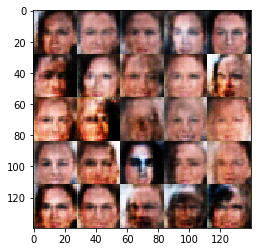

Epoch 0/1... Discriminator Loss: 0.8179... Generator Loss: 1.1516
Epoch 0/1... Discriminator Loss: 1.1009... Generator Loss: 0.9359
Epoch 0/1... Discriminator Loss: 1.1129... Generator Loss: 0.6334
Epoch 0/1... Discriminator Loss: 1.0490... Generator Loss: 0.8057
Epoch 0/1... Discriminator Loss: 0.9428... Generator Loss: 2.1630
Epoch 0/1... Discriminator Loss: 1.2888... Generator Loss: 1.7242
Epoch 0/1... Discriminator Loss: 1.0291... Generator Loss: 0.8653
Epoch 0/1... Discriminator Loss: 0.9547... Generator Loss: 1.6383
Epoch 0/1... Discriminator Loss: 0.8179... Generator Loss: 1.4358
Epoch 0/1... Discriminator Loss: 1.3321... Generator Loss: 0.4214


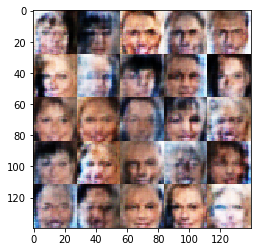

Epoch 0/1... Discriminator Loss: 1.1870... Generator Loss: 0.6930
Epoch 0/1... Discriminator Loss: 0.9013... Generator Loss: 1.2766
Epoch 0/1... Discriminator Loss: 1.1140... Generator Loss: 0.6574
Epoch 0/1... Discriminator Loss: 0.9407... Generator Loss: 2.3810
Epoch 0/1... Discriminator Loss: 0.7574... Generator Loss: 1.5383
Epoch 0/1... Discriminator Loss: 1.0491... Generator Loss: 1.7070
Epoch 0/1... Discriminator Loss: 1.4845... Generator Loss: 2.2786
Epoch 0/1... Discriminator Loss: 1.3539... Generator Loss: 1.0446
Epoch 0/1... Discriminator Loss: 1.4208... Generator Loss: 1.8412
Epoch 0/1... Discriminator Loss: 1.0805... Generator Loss: 1.5066


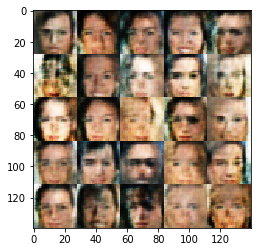

Epoch 0/1... Discriminator Loss: 1.5686... Generator Loss: 0.3442
Epoch 0/1... Discriminator Loss: 1.2379... Generator Loss: 0.5389
Epoch 0/1... Discriminator Loss: 1.0321... Generator Loss: 2.4328
Epoch 0/1... Discriminator Loss: 1.0356... Generator Loss: 0.9412
Epoch 0/1... Discriminator Loss: 1.2536... Generator Loss: 0.8754
Epoch 0/1... Discriminator Loss: 1.0302... Generator Loss: 0.7655
Epoch 0/1... Discriminator Loss: 0.8682... Generator Loss: 1.2910
Epoch 0/1... Discriminator Loss: 1.7516... Generator Loss: 3.0809
Epoch 0/1... Discriminator Loss: 0.8499... Generator Loss: 1.3562
Epoch 0/1... Discriminator Loss: 1.0295... Generator Loss: 0.7197


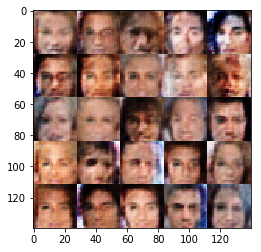

Epoch 0/1... Discriminator Loss: 1.1249... Generator Loss: 0.5973
Epoch 0/1... Discriminator Loss: 0.8195... Generator Loss: 1.2634
Epoch 0/1... Discriminator Loss: 1.3868... Generator Loss: 0.4339
Epoch 0/1... Discriminator Loss: 1.4014... Generator Loss: 0.3793
Epoch 0/1... Discriminator Loss: 0.9951... Generator Loss: 1.3219
Epoch 0/1... Discriminator Loss: 1.4385... Generator Loss: 0.3595
Epoch 0/1... Discriminator Loss: 1.0310... Generator Loss: 0.9118
Epoch 0/1... Discriminator Loss: 0.8610... Generator Loss: 1.4488
Epoch 0/1... Discriminator Loss: 0.6999... Generator Loss: 1.4386
Epoch 0/1... Discriminator Loss: 1.5069... Generator Loss: 0.7303


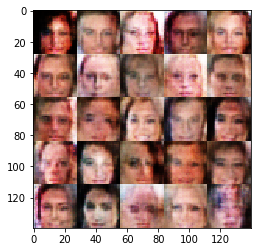

Epoch 0/1... Discriminator Loss: 1.4558... Generator Loss: 2.6522
Epoch 0/1... Discriminator Loss: 0.6096... Generator Loss: 1.8791
Epoch 0/1... Discriminator Loss: 1.0884... Generator Loss: 0.8844
Epoch 0/1... Discriminator Loss: 0.7379... Generator Loss: 1.5236
Epoch 0/1... Discriminator Loss: 0.9150... Generator Loss: 1.5417
Epoch 0/1... Discriminator Loss: 0.9218... Generator Loss: 1.3263
Epoch 0/1... Discriminator Loss: 1.3597... Generator Loss: 0.6007
Epoch 0/1... Discriminator Loss: 1.0730... Generator Loss: 0.6336
Epoch 0/1... Discriminator Loss: 1.1080... Generator Loss: 0.6665
Epoch 0/1... Discriminator Loss: 0.9610... Generator Loss: 0.8136


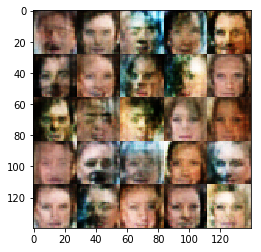

Epoch 0/1... Discriminator Loss: 1.1710... Generator Loss: 1.0289
Epoch 0/1... Discriminator Loss: 1.3917... Generator Loss: 0.4104
Epoch 0/1... Discriminator Loss: 1.0550... Generator Loss: 0.8923
Epoch 0/1... Discriminator Loss: 0.7983... Generator Loss: 1.9539
Epoch 0/1... Discriminator Loss: 0.9969... Generator Loss: 1.2937
Epoch 0/1... Discriminator Loss: 0.8445... Generator Loss: 1.0414
Epoch 0/1... Discriminator Loss: 1.4243... Generator Loss: 0.3442
Epoch 0/1... Discriminator Loss: 1.1498... Generator Loss: 0.8741
Epoch 0/1... Discriminator Loss: 1.2063... Generator Loss: 0.5241
Epoch 0/1... Discriminator Loss: 0.7798... Generator Loss: 0.9840


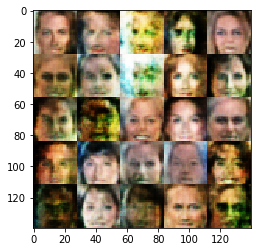

Epoch 0/1... Discriminator Loss: 1.5510... Generator Loss: 1.6012
Epoch 0/1... Discriminator Loss: 1.0098... Generator Loss: 1.0187
Epoch 0/1... Discriminator Loss: 1.0012... Generator Loss: 0.7214
Epoch 0/1... Discriminator Loss: 0.9737... Generator Loss: 0.9445
Epoch 0/1... Discriminator Loss: 1.1591... Generator Loss: 0.5991
Epoch 0/1... Discriminator Loss: 1.1003... Generator Loss: 0.5493
Epoch 0/1... Discriminator Loss: 0.8336... Generator Loss: 0.9540
Epoch 0/1... Discriminator Loss: 1.0923... Generator Loss: 0.8609
Epoch 0/1... Discriminator Loss: 0.9931... Generator Loss: 0.7933
Epoch 0/1... Discriminator Loss: 0.6740... Generator Loss: 1.2802


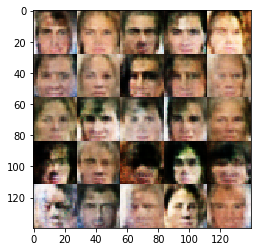

Epoch 0/1... Discriminator Loss: 1.2910... Generator Loss: 0.5282
Epoch 0/1... Discriminator Loss: 0.6923... Generator Loss: 1.2579
Epoch 0/1... Discriminator Loss: 1.0754... Generator Loss: 0.7390
Epoch 0/1... Discriminator Loss: 1.0797... Generator Loss: 0.7988
Epoch 0/1... Discriminator Loss: 1.0401... Generator Loss: 0.7450
Epoch 0/1... Discriminator Loss: 1.2486... Generator Loss: 0.6180
Epoch 0/1... Discriminator Loss: 1.0424... Generator Loss: 2.1509
Epoch 0/1... Discriminator Loss: 1.1228... Generator Loss: 1.5512
Epoch 0/1... Discriminator Loss: 1.3660... Generator Loss: 0.4175
Epoch 0/1... Discriminator Loss: 0.8549... Generator Loss: 1.0205


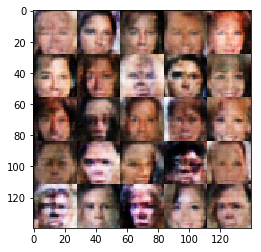

Epoch 0/1... Discriminator Loss: 1.3841... Generator Loss: 0.4279
Epoch 0/1... Discriminator Loss: 0.7274... Generator Loss: 1.0755
Epoch 0/1... Discriminator Loss: 0.8098... Generator Loss: 1.7140
Epoch 0/1... Discriminator Loss: 0.9026... Generator Loss: 3.3860
Epoch 0/1... Discriminator Loss: 0.5466... Generator Loss: 2.1810
Epoch 0/1... Discriminator Loss: 1.1657... Generator Loss: 0.6196
Epoch 0/1... Discriminator Loss: 0.9555... Generator Loss: 1.1400
Epoch 0/1... Discriminator Loss: 0.5522... Generator Loss: 1.7232
Epoch 0/1... Discriminator Loss: 0.9513... Generator Loss: 1.2990
Epoch 0/1... Discriminator Loss: 1.2695... Generator Loss: 0.4984


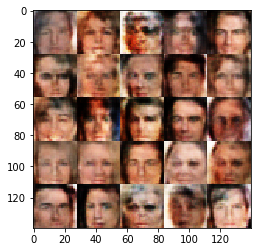

Epoch 0/1... Discriminator Loss: 1.0972... Generator Loss: 0.6782
Epoch 0/1... Discriminator Loss: 0.6032... Generator Loss: 1.6434
Epoch 0/1... Discriminator Loss: 1.2691... Generator Loss: 2.0099
Epoch 0/1... Discriminator Loss: 0.8804... Generator Loss: 0.9329
Epoch 0/1... Discriminator Loss: 1.2754... Generator Loss: 0.4749
Epoch 0/1... Discriminator Loss: 1.0452... Generator Loss: 0.7469
Epoch 0/1... Discriminator Loss: 0.7917... Generator Loss: 0.9400
Epoch 0/1... Discriminator Loss: 1.8817... Generator Loss: 0.2228
Epoch 0/1... Discriminator Loss: 1.4544... Generator Loss: 0.3754
Epoch 0/1... Discriminator Loss: 0.8945... Generator Loss: 0.9214


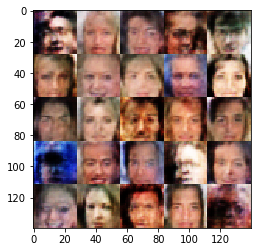

Epoch 0/1... Discriminator Loss: 0.9135... Generator Loss: 1.1549
Epoch 0/1... Discriminator Loss: 1.0025... Generator Loss: 1.7346
Epoch 0/1... Discriminator Loss: 1.3717... Generator Loss: 0.4681
Epoch 0/1... Discriminator Loss: 0.9029... Generator Loss: 1.1004
Epoch 0/1... Discriminator Loss: 1.3250... Generator Loss: 0.4391
Epoch 0/1... Discriminator Loss: 1.0017... Generator Loss: 0.6322
Epoch 0/1... Discriminator Loss: 1.0114... Generator Loss: 0.6313
Epoch 0/1... Discriminator Loss: 0.7972... Generator Loss: 1.4916
Epoch 0/1... Discriminator Loss: 0.8860... Generator Loss: 0.7162
Epoch 0/1... Discriminator Loss: 1.9067... Generator Loss: 0.2423


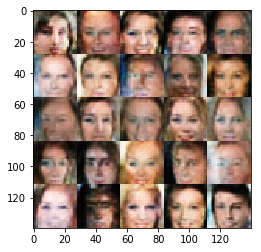

Epoch 0/1... Discriminator Loss: 1.1415... Generator Loss: 0.8806
Epoch 0/1... Discriminator Loss: 1.0697... Generator Loss: 0.8668
Epoch 0/1... Discriminator Loss: 1.2816... Generator Loss: 1.6376
Epoch 0/1... Discriminator Loss: 1.0112... Generator Loss: 0.8365
Epoch 0/1... Discriminator Loss: 0.7834... Generator Loss: 1.2956
Epoch 0/1... Discriminator Loss: 1.3889... Generator Loss: 1.7749
Epoch 0/1... Discriminator Loss: 0.7704... Generator Loss: 1.2953
Epoch 0/1... Discriminator Loss: 1.6633... Generator Loss: 0.3159
Epoch 0/1... Discriminator Loss: 0.8752... Generator Loss: 1.0382
Epoch 0/1... Discriminator Loss: 0.8805... Generator Loss: 2.7193


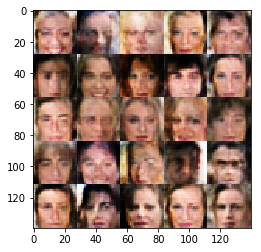

Epoch 0/1... Discriminator Loss: 1.0161... Generator Loss: 1.9944
Epoch 0/1... Discriminator Loss: 1.0770... Generator Loss: 0.9769
Epoch 0/1... Discriminator Loss: 0.7453... Generator Loss: 1.0760
Epoch 0/1... Discriminator Loss: 0.8694... Generator Loss: 1.0712
Epoch 0/1... Discriminator Loss: 0.7342... Generator Loss: 1.1377
Epoch 0/1... Discriminator Loss: 1.0517... Generator Loss: 0.9286
Epoch 0/1... Discriminator Loss: 1.0106... Generator Loss: 0.7611
Epoch 0/1... Discriminator Loss: 0.5956... Generator Loss: 1.6280
Epoch 0/1... Discriminator Loss: 1.9037... Generator Loss: 1.8276
Epoch 0/1... Discriminator Loss: 0.8896... Generator Loss: 0.9446


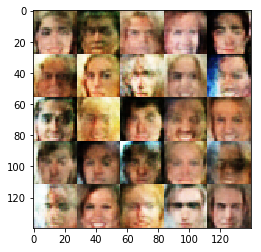

Epoch 0/1... Discriminator Loss: 0.7114... Generator Loss: 1.3061
Epoch 0/1... Discriminator Loss: 1.1914... Generator Loss: 1.0615
Epoch 0/1... Discriminator Loss: 1.2766... Generator Loss: 0.4686
Epoch 0/1... Discriminator Loss: 1.7033... Generator Loss: 0.2797
Epoch 0/1... Discriminator Loss: 1.6019... Generator Loss: 0.3520
Epoch 0/1... Discriminator Loss: 1.0429... Generator Loss: 0.9860
Epoch 0/1... Discriminator Loss: 1.7048... Generator Loss: 0.3441
Epoch 0/1... Discriminator Loss: 0.7596... Generator Loss: 1.6400
Epoch 0/1... Discriminator Loss: 0.7482... Generator Loss: 1.0080
Epoch 0/1... Discriminator Loss: 0.6664... Generator Loss: 1.4009


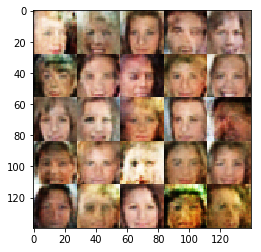

Epoch 0/1... Discriminator Loss: 1.1620... Generator Loss: 1.2796
Epoch 0/1... Discriminator Loss: 1.3955... Generator Loss: 2.2123
Epoch 0/1... Discriminator Loss: 0.7970... Generator Loss: 1.9485
Epoch 0/1... Discriminator Loss: 0.8362... Generator Loss: 0.9535
Epoch 0/1... Discriminator Loss: 1.2831... Generator Loss: 1.7051
Epoch 0/1... Discriminator Loss: 1.1133... Generator Loss: 2.2336
Epoch 0/1... Discriminator Loss: 0.6756... Generator Loss: 1.0857
Epoch 0/1... Discriminator Loss: 0.8508... Generator Loss: 0.9670
Epoch 0/1... Discriminator Loss: 0.9239... Generator Loss: 1.1433
Epoch 0/1... Discriminator Loss: 0.9429... Generator Loss: 0.8597


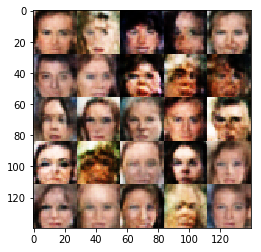

Epoch 0/1... Discriminator Loss: 0.6281... Generator Loss: 1.4006
Epoch 0/1... Discriminator Loss: 0.9325... Generator Loss: 0.7412
Epoch 0/1... Discriminator Loss: 0.9516... Generator Loss: 1.1080
Epoch 0/1... Discriminator Loss: 1.4676... Generator Loss: 0.5206
Epoch 0/1... Discriminator Loss: 1.2688... Generator Loss: 1.4835
Epoch 0/1... Discriminator Loss: 1.0269... Generator Loss: 0.6576
Epoch 0/1... Discriminator Loss: 0.6681... Generator Loss: 1.2601
Epoch 0/1... Discriminator Loss: 1.3025... Generator Loss: 0.4499
Epoch 0/1... Discriminator Loss: 0.8280... Generator Loss: 1.3399
Epoch 0/1... Discriminator Loss: 1.2989... Generator Loss: 1.3885


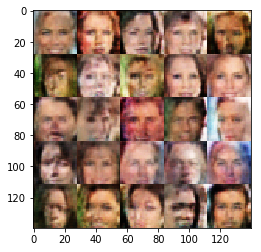

Epoch 0/1... Discriminator Loss: 0.9136... Generator Loss: 1.5444
Epoch 0/1... Discriminator Loss: 1.0939... Generator Loss: 0.8140
Epoch 0/1... Discriminator Loss: 1.0746... Generator Loss: 0.7779
Epoch 0/1... Discriminator Loss: 1.0205... Generator Loss: 0.7002
Epoch 0/1... Discriminator Loss: 1.0041... Generator Loss: 2.2392
Epoch 0/1... Discriminator Loss: 0.8169... Generator Loss: 1.2318
Epoch 0/1... Discriminator Loss: 0.4888... Generator Loss: 2.7255
Epoch 0/1... Discriminator Loss: 1.1021... Generator Loss: 1.4442
Epoch 0/1... Discriminator Loss: 1.2947... Generator Loss: 0.4429
Epoch 0/1... Discriminator Loss: 1.2711... Generator Loss: 0.4254


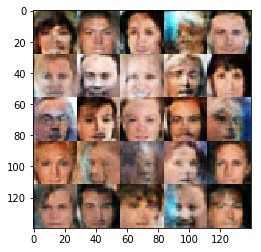

Epoch 0/1... Discriminator Loss: 0.7755... Generator Loss: 1.5756
Epoch 0/1... Discriminator Loss: 0.8690... Generator Loss: 1.8254
Epoch 0/1... Discriminator Loss: 0.9833... Generator Loss: 1.8185
Epoch 0/1... Discriminator Loss: 0.6547... Generator Loss: 1.3466
Epoch 0/1... Discriminator Loss: 0.7094... Generator Loss: 1.6370
Epoch 0/1... Discriminator Loss: 1.1578... Generator Loss: 0.5333
Epoch 0/1... Discriminator Loss: 1.0118... Generator Loss: 0.9440
Epoch 0/1... Discriminator Loss: 1.4321... Generator Loss: 0.4146
Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 0.8049
Epoch 0/1... Discriminator Loss: 0.7720... Generator Loss: 0.8610


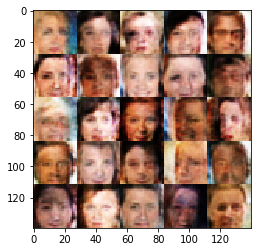

Epoch 0/1... Discriminator Loss: 0.8963... Generator Loss: 1.0684
Epoch 0/1... Discriminator Loss: 0.9919... Generator Loss: 0.8453
Epoch 0/1... Discriminator Loss: 0.8237... Generator Loss: 0.9517
Epoch 0/1... Discriminator Loss: 1.0564... Generator Loss: 0.8553
Epoch 0/1... Discriminator Loss: 0.9558... Generator Loss: 0.9037
Epoch 0/1... Discriminator Loss: 1.3466... Generator Loss: 2.0858
Epoch 0/1... Discriminator Loss: 0.6919... Generator Loss: 1.7106
Epoch 0/1... Discriminator Loss: 0.6739... Generator Loss: 1.3521
Epoch 0/1... Discriminator Loss: 0.9253... Generator Loss: 2.2155
Epoch 0/1... Discriminator Loss: 1.5582... Generator Loss: 0.3317


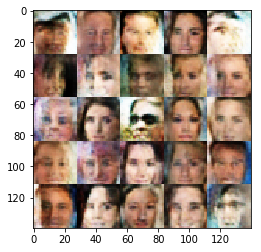

Epoch 0/1... Discriminator Loss: 0.8489... Generator Loss: 1.3020
Epoch 0/1... Discriminator Loss: 0.8994... Generator Loss: 0.7786
Epoch 0/1... Discriminator Loss: 1.0528... Generator Loss: 0.7226
Epoch 0/1... Discriminator Loss: 0.7440... Generator Loss: 1.9349
Epoch 0/1... Discriminator Loss: 1.3080... Generator Loss: 2.6502
Epoch 0/1... Discriminator Loss: 0.6538... Generator Loss: 1.2480
Epoch 0/1... Discriminator Loss: 1.3068... Generator Loss: 2.3928
Epoch 0/1... Discriminator Loss: 0.8120... Generator Loss: 0.9724
Epoch 0/1... Discriminator Loss: 1.0377... Generator Loss: 0.7705
Epoch 0/1... Discriminator Loss: 1.2884... Generator Loss: 0.5748


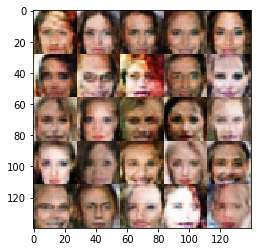

Epoch 0/1... Discriminator Loss: 0.8121... Generator Loss: 1.3194
Epoch 0/1... Discriminator Loss: 0.5191... Generator Loss: 2.0022
Epoch 0/1... Discriminator Loss: 0.8228... Generator Loss: 1.3202
Epoch 0/1... Discriminator Loss: 1.1287... Generator Loss: 0.6022
Epoch 0/1... Discriminator Loss: 1.4372... Generator Loss: 0.3947
Epoch 0/1... Discriminator Loss: 1.1894... Generator Loss: 0.5153
Epoch 0/1... Discriminator Loss: 1.2722... Generator Loss: 0.4344


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.